In [1]:
## general
import numpy as np
import datetime
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt
import matplotlib as mpl
import math
import pandas as pd

## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro  #check normalicy of seasonal trend distribution
from scipy.optimize import curve_fit, fmin, fminbound, minimize, rosen_der, least_squares
from sklearn.preprocessing import StandardScaler
import pickle

##import functions for fitting
from symfit import parameters, variables, Fit
from symfit import pi,sqrt,log,exp,sinh
from symfit import sin, cos


# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/tristan/mesmer/tools/')
from loading import load_data_single_mod
from processing import AR1_predict, compute_llh_cv,gaspari_cohn
from plotting import TaylorDiagram


## plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mplotutils as mpu

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed
from sklearn.externals import joblib

ValueError: r_home is None. Try python -m rpy2.situation

In [2]:
def combine_dims(a, start=0, count=2):
    """Reshapes numpy array a by combining count dimensions, 
    starting at the dimension index start"""
    
    s = a.shape
    return np.reshape(a, s[:start] + (-1,) + s[start+count:])

In [13]:
def compute_wgt_reg_emu_mon(reg, y_mon_sel):
    
    dir_data = "/home/tristan/mesmer/data/"
    file_ls = "interim_invariant_lsmask_regrid.nc"
    file_obs = "obs_data_25.nc"
    file_srex = "srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc"
    file_srex_shape = "referenceRegions.shp"

    df_obs=xr.open_mfdataset(dir_data+file_obs)

    # SREX names ordered according to SREX mask
    srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] 
        
    # srex_raw nrs from 1-26
    srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
    lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values) #derive the lat, lon grid
    
    #apply land mask
    frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
    frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
    frac_l = frac_l.where(frac_l.lat>-60,0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 
    
    wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
    wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
    lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh
    srex = (np.squeeze(srex_raw.srex_mask.values)-1)[idx_l] # srex indices on land

    
    if reg == 'Global_land':
        idx_reg_l=np.ones(3043,dtype=bool)
        idx_reg_l_grid = copy.deepcopy(idx_l)
        
    else:
        idx_reg = srex_names.index(reg) # index region
        idx_reg_l = (srex==idx_reg) #index land (l) gp inside specific srex region (reg)
        srex_grid=np.zeros(idx_l.shape)
        srex_grid[idx_l]=srex # ATTENTION: not 100% convinced yet if this is correct (I get some missing values that
        idx_reg_l_grid = (srex_grid==idx_reg)#& idx_l 
    
    y_mon_sel_reg = {}
    
    for run in np.arange(len(y_mon_sel)):
        y_mon_sel_reg[run] = np.zeros(len(y_mon_sel[0]))
        for i in np.arange(len(y_mon_sel[0])):
            idx_valid = ~np.isnan(y_mon_sel[run])
            y_mon_sel_reg[run][i] = np.average(y_mon_sel[run][i][idx_reg_l], weights=wgt_l[idx_reg_l])
        
    return y_mon_sel_reg

In [4]:
dir_data = '/home/tristan/mesmer_data/output/saved-Jul/'
dir_data_big = '/home/tristan/mesmer_data/output/'

start = dt.datetime.now()

emulator_innovations = joblib.load(dir_data_big+'120_emulator_innovations_fmin_log.pkl')
seasonal_trend = joblib.load(dir_data+'seasonal_training_results.pkl')


time_taken = dt.datetime.now() - start
print('time take to load %i emulations: ' %len(emulator_innovations), time_taken)

time take to load 120 emulations:  0:00:10.150775


In [5]:
# create y_all_mon and y_all (gridpoint (not averaged accross any region) data) for the emulations

y_all_mon = {}
y_all = {}

for run in tqdm(np.arange(len(emulator_innovations))):
    y_all_mon[run] = combine_dims(emulator_innovations[run], 0)
    y_all_mon[run] = np.add(y_all_mon[run], seasonal_trend)
    y_all[run] = np.mean(y_all_mon[run].reshape(-1,12,3043),axis=1)

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/120 [00:00<?, ?it/s]

In [26]:
## select monthly data for Jan
y_jan = {}
for run in np.arange(len(emulator_innovations)):
    y_jan[run] = y_all_mon[run][0::12]

In [27]:
len(y_jan[0])

112

In [28]:
y_jan_gl = compute_wgt_reg_emu_mon('Global_land', y_jan)

In [29]:
y_jan_gl[8].max()

-5.816349221185005

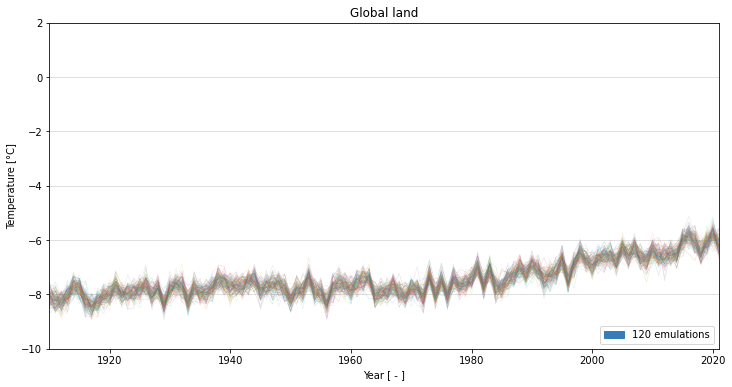

In [31]:
#for annual data
time_ann = pd.date_range('1910-01-01', '2021-12-31', freq='AS')

fig=plt.figure(figsize=(12,6))

### set boundaries for y-axis
y_min = -10.0
y_max = 2.0
plt.ylim([y_min,y_max])

##create legend
runs_lg = mpatches.Patch(color="#377eb8", label="120 emulations")

for run in np.arange(len(y_jan)):
        plt.plot(time_ann, y_jan_gl[run], lw=0.5, alpha=0.2)

#for dataset in datasets:
    #plt.plot(time_obs_ann, obs_ann[dataset], color="k", alpha=0.35)

plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('Global land')
plt.xlabel('Year [ - ]')
plt.ylabel('Temperature [°C]')
leg = plt.legend(handles=[runs_lg], loc="lower right", prop={'size': 10})

# ax_sub = fig.add_axes([0.15, 0.65, 0.2, 0.2],projection=ccrs.Robinson(central_longitude=0))
# mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_gl, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
# ax_sub.coastlines(lw=0.5)
# ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

plt.show()